Perform Exploratory data analysis on structured, unstructured and image text data



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, RocCurveDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

from nltk import PorterStemmer, WordNetLemmatizer, word_tokenize
from nltk.corpus import stopwords
import string
import re
from collections import Counter

from scipy.stats import ttest_ind
from sklearn.feature_selection import chi2

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import models, layers


**Tabular DATA**

In [ ]:
df = pd.read_csv("/content/diabetes (2).csv")

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


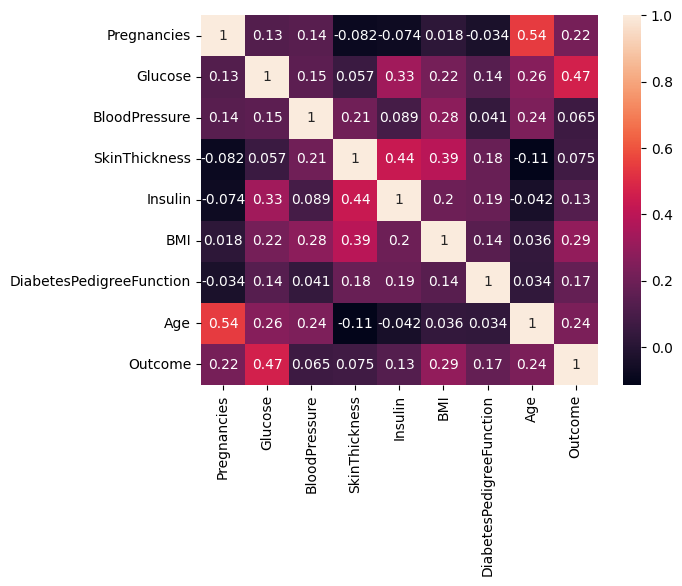

In [ ]:
sns.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
stats = df.describe().T[['mean','std']]
stats['variance'] = df.var()
stats

,mean,std,variance
Pregnancies,3.845052,3.369578,11.354056
Glucose,120.894531,31.972618,1022.248314
BloodPressure,69.105469,19.355807,374.647271
SkinThickness,20.536458,15.952218,254.473245
Insulin,79.799479,115.244002,13281.180078
BMI,31.992578,7.884160,62.159984
DiabetesPedigreeFunction,0.471876,0.331329,0.109779
Age,33.240885,11.760232,138.303046
Outcome,0.348958,0.476951,0.227483


In [ ]:
label_df = df.copy()
for col in label_df.select_dtypes(include='object').columns:
  label_df[col] = LabelEncoder().fit_transform(label_df[col])

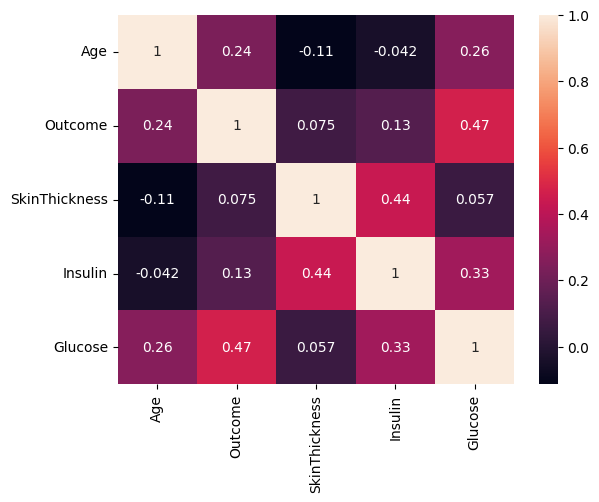

In [ ]:
X = MinMaxScaler().fit_transform(label_df.dropna())

chi_vals, _ = chi2(X, label_df.iloc[:,0])
chi_df = pd.Series(chi_vals, index=label_df.columns).sort_values(ascending=False)
top_corr = chi_df[1:6].index.tolist()

sns.heatmap(label_df[top_corr].corr(), annot = True)
plt.show()

In [ ]:
for col in df.select_dtypes(include='number').columns:
  x = df[col]
  min_lim = np.mean(df[col]) - np.std(df[col])*np.sqrt(df[col].abs().mean())
  max_lim = np.mean(df[col]) + np.std(df[col])*np.sqrt(df[col].abs().mean())
  outliers = (x < max_lim) | (x > min_lim)
  print(f'For {col}: \n\tOutliers {"Exist" if all(outliers) else "Not Exist"}\n\tMAX:{round(max_lim,4)}\n\t\tMIN:{round(min_lim,4)}')
  print("-------------------------------")

For Pregnancies: 
	Outliers Exist
	MAX:10.4481
		MIN:-2.758
-------------------------------
For Glucose: 
	Outliers Exist
	MAX:472.2111
		MIN:-230.422
-------------------------------
For BloodPressure: 
	Outliers Exist
	MAX:229.9049
		MIN:-91.694
-------------------------------
For SkinThickness: 
	Outliers Exist
	MAX:92.7803
		MIN:-51.7074
-------------------------------
For Insulin: 
	Outliers Exist
	MAX:1108.6101
		MIN:-949.0111
-------------------------------
For BMI: 
	Outliers Exist
	MAX:76.5579
		MIN:-12.5728
-------------------------------
For DiabetesPedigreeFunction: 
	Outliers Exist
	MAX:0.6993
		MIN:0.2444
-------------------------------
For Age: 
	Outliers Exist
	MAX:101.0002
		MIN:-34.5185
-------------------------------
For Outcome: 
	Outliers Exist
	MAX:0.6305
		MIN:0.0674
-------------------------------


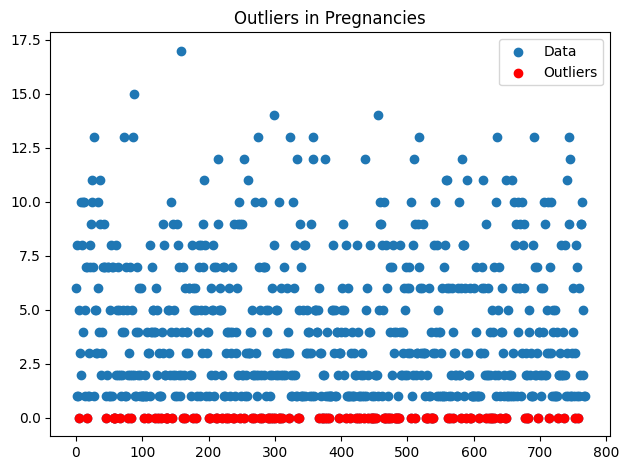

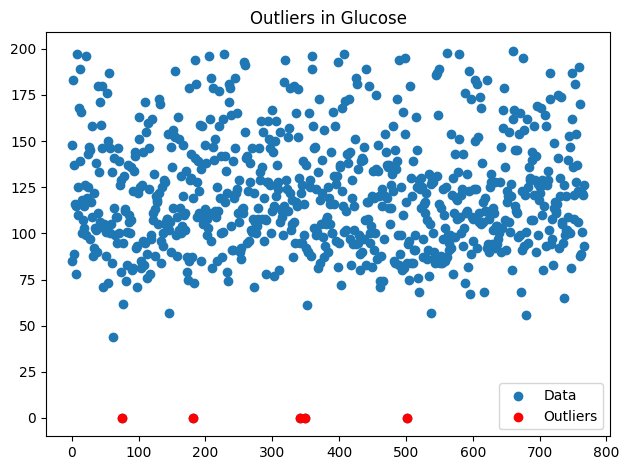

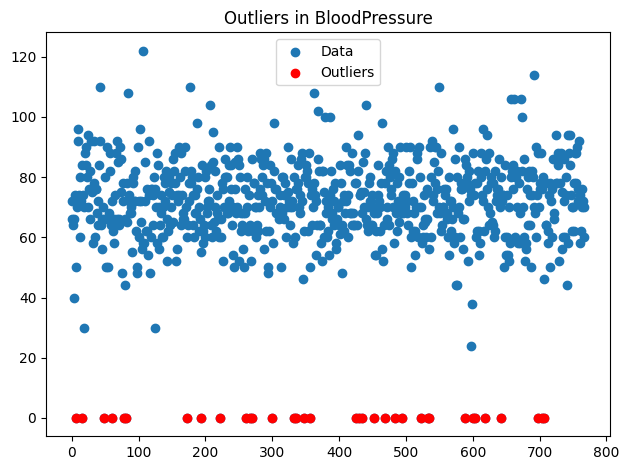

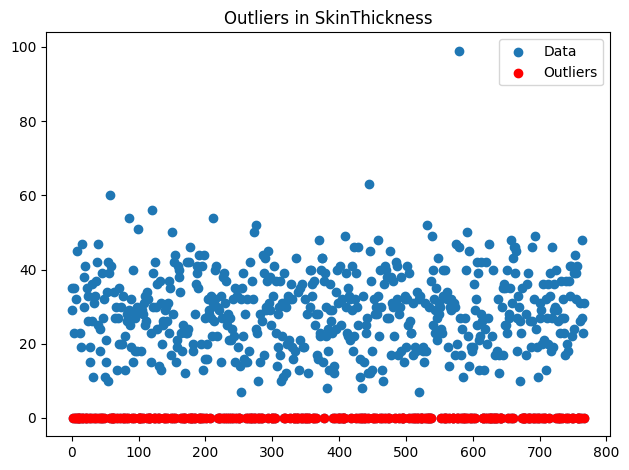

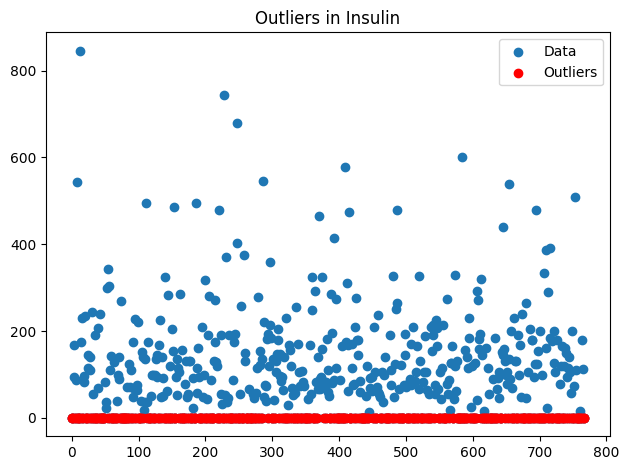

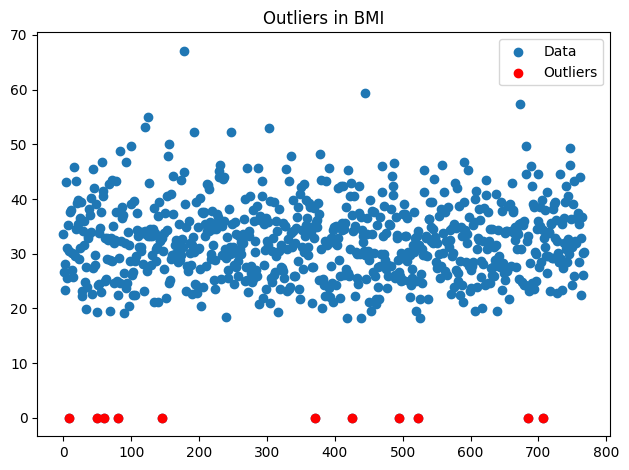

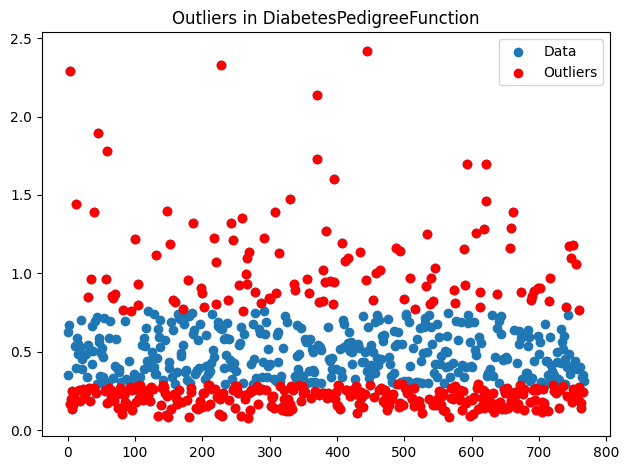

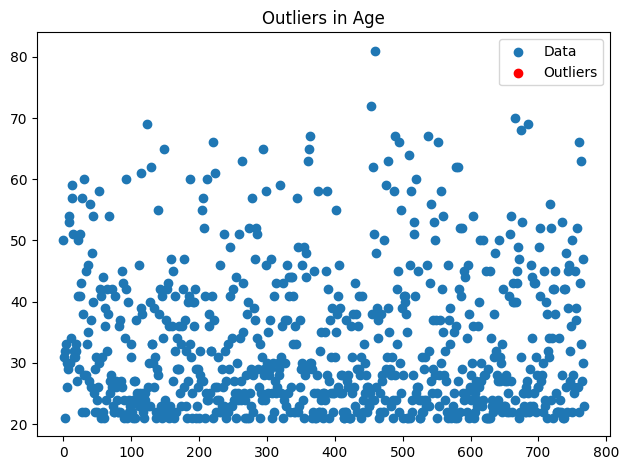

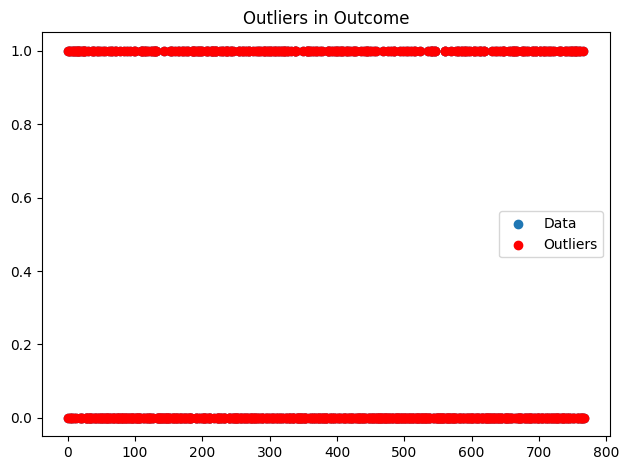

In [ ]:
for col in df.select_dtypes(include='number').columns:
    x = df[col]
    min_lim = x.mean() + x.std() * np.sqrt(x)
    max_lim = x.mean() - x.std() * np.sqrt(x)
    outliers = (x < max_lim) | (x > min_lim)

    # Outlier visualization
    plt.figure()
    plt.scatter(df.index, x, label='Data')
    plt.scatter(df.index[outliers], x[outliers], color='red', label='Outliers')
    plt.title(f"Outliers in {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

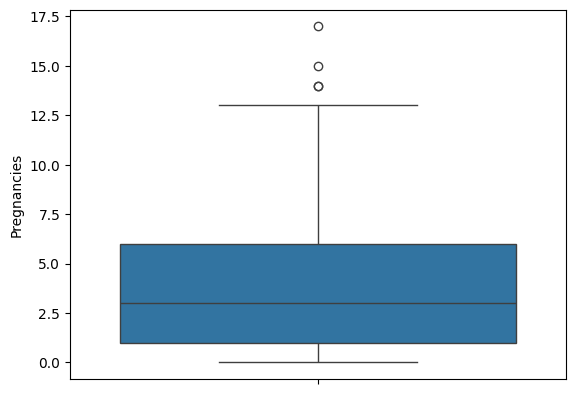

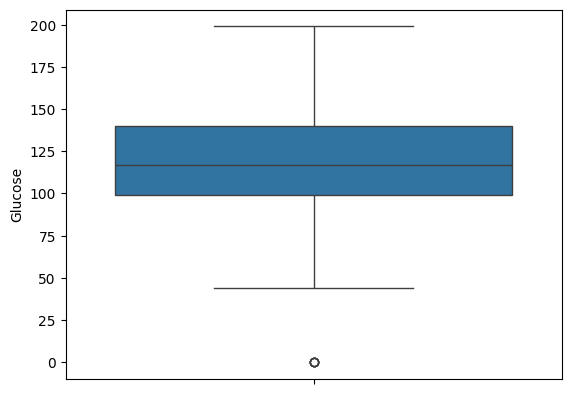

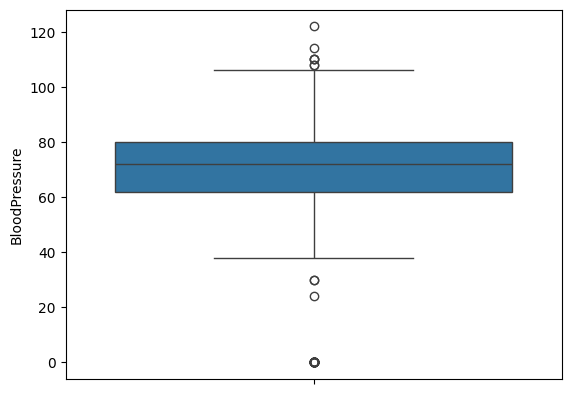

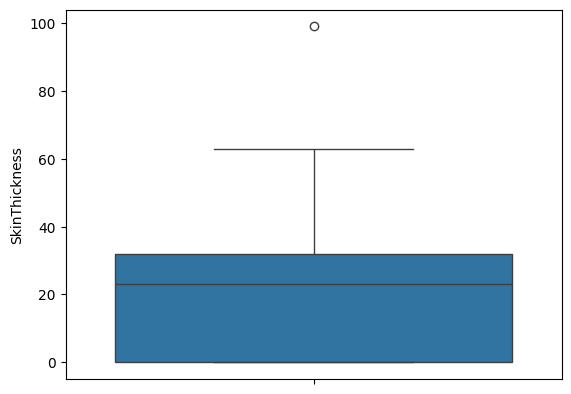

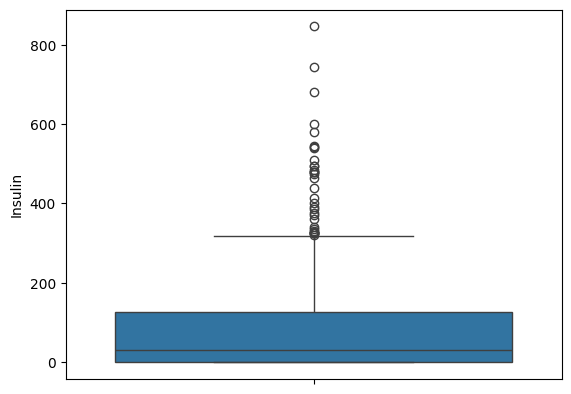

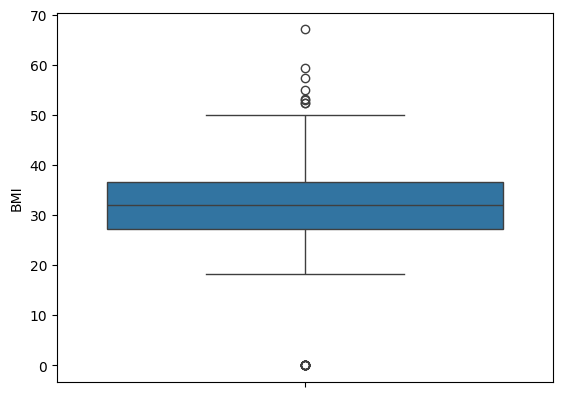

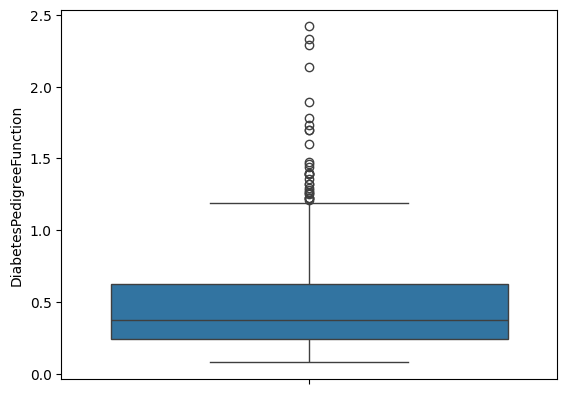

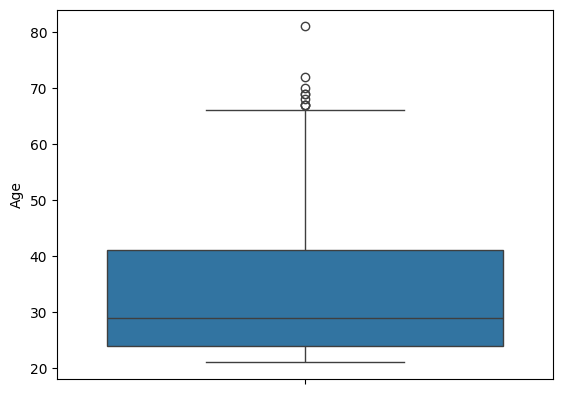

In [ ]:
for col in df.drop('Outcome', axis=1).select_dtypes(include='number').columns:
  x = df[col]
  sns.boxplot(df[col])
  plt.show()

**Image DATA**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


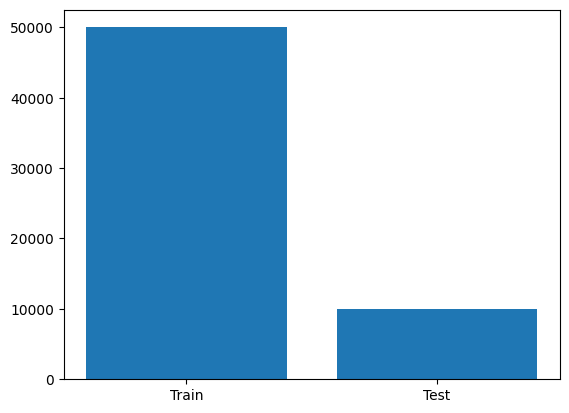

In [ ]:
plt.bar(['Train','Test'],[len(x_train), len(x_test)])
plt.show()

In [ ]:
modela = models.Sequential([
    layers.Conv2D(32, 3, input_shape = (32,32,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3,activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modelb = models.Sequential([
    layers.Rescaling(1./255, input_shape=(32,32,3)),
    layers.Flatten(), layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'), layers.Dense(len(class_names))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
for m in [modela, modelb]:
    m.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
h1 = modela.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)
h2 = modelb.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 52ms/step - accuracy: 0.3618 - loss: 1.7095 - val_accuracy: 0.5633 - val_loss: 1.2343
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.6073 - loss: 1.1031 - val_accuracy: 0.6307 - val_loss: 1.0530
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2024 - loss: 2.1393 - val_accuracy: 0.2999 - val_loss: 1.9246
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3070 - loss: 1.9119 - val_accuracy: 0.3255 - val_loss: 1.8650
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3273 - loss: 1.8616 - val_accuracy: 0.3439 - val_loss: 1.8241


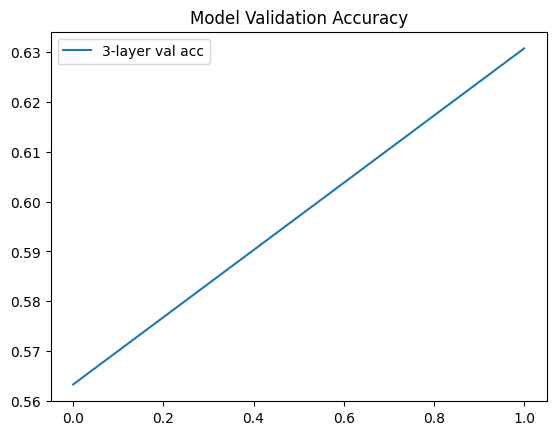

In [ ]:
plt.plot(h1.history['val_accuracy'], label='3-layer val acc')
plt.legend();
plt.title("Model Validation Accuracy");
plt.show()

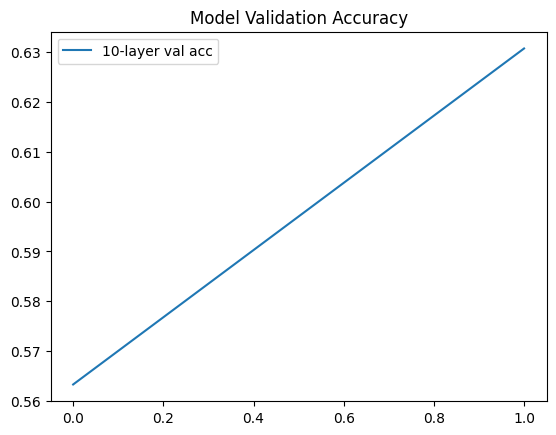

In [ ]:
plt.plot(h1.history['val_accuracy'], label='10-layer val acc')
plt.legend();
plt.title("Model Validation Accuracy");
plt.show()

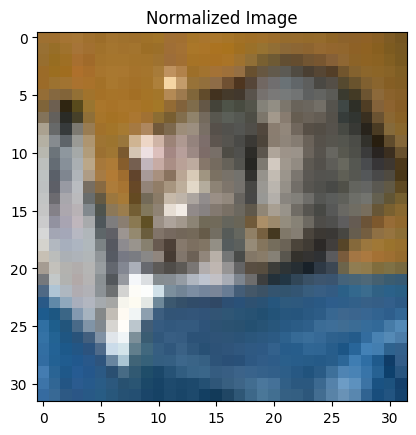

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predicted: cat | Actual: cat


<ipython-input-23-164c5056a5d0>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted:", class_names[int(pred)], "| Actual:", class_names[int(y_test[i])])


In [ ]:
i = 0
plt.imshow(x_test[i]);
plt.title("Normalized Image");
plt.show()
pred = tf.argmax(modela.predict(x_test[i:i+1]), axis=1)
print("Predicted:", class_names[int(pred)], "| Actual:", class_names[int(y_test[i])])

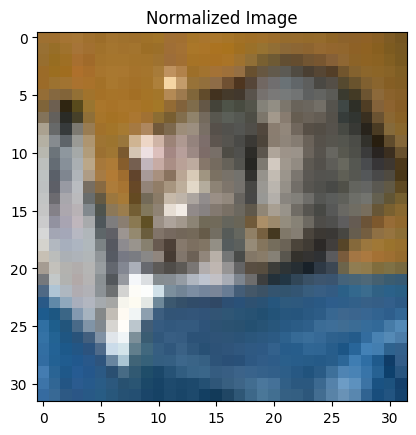

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted: dog | Actual: cat


<ipython-input-24-1086e445d64b>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted:", class_names[int(pred)], "| Actual:", class_names[int(y_test[i])])


In [ ]:
i = 0
plt.imshow(x_test[i]);
plt.title("Normalized Image");
plt.show()
pred = tf.argmax(modelb.predict(x_test[i:i+1]), axis=1)
print("Predicted:", class_names[int(pred)], "| Actual:", class_names[int(y_test[i])])

In [ ]:
extract = tf.keras.Model(inputs=modela.input, outputs=modela.layers[-2].output)
features = extract.predict(x_test[:1000])
tsne = TSNE(n_components=2).fit_transform(features)
plt.scatter(tsne[:,0], tsne[:,1], c=y_test[:1000].flatten(), cmap='tab10', s=10)
plt.title("t-SNE of 3-layer Features");
plt.show()

AttributeError: The layer sequential has never been called and thus has no defined input.

**Text DATA**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv("/content/twitter_training.csv")
df.columns = ['ID','entity','sentiment','content']
df

,ID,entity,sentiment,content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
Negative,22542
Positive,20831
Neutral,18318
Irrelevant,12990


In [ ]:
df = df[['sentiment','content']]
df

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [ ]:
df['length'] = df['content'].str.len()

<ipython-input-35-b9817a327593>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df['content'].str.len()


In [ ]:
df

,sentiment,content,length
0,Positive,I am coming to the borders and I will kill you...,51.0
1,Positive,im getting on borderlands and i will kill you ...,50.0
2,Positive,im coming on borderlands and i will murder you...,51.0
3,Positive,im getting on borderlands 2 and i will murder ...,57.0
4,Positive,im getting into borderlands and i can murder y...,53.0
...,...,...,...
74676,Positive,Just realized that the Windows partition of my...,128.0
74677,Positive,Just realized that my Mac window partition is ...,117.0
74678,Positive,Just realized the windows partition of my Mac ...,125.0
74679,Positive,Just realized between the windows partition of...,159.0


In [ ]:
def word_count(tweet):
  words = str(tweet).split()
  return len(words)

df['word_count'] = df['content'].apply(word_count)

In [ ]:
df

,sentiment,content,length,word_count
0,Positive,I am coming to the borders and I will kill you...,51.0,12
1,Positive,im getting on borderlands and i will kill you ...,50.0,10
2,Positive,im coming on borderlands and i will murder you...,51.0,10
3,Positive,im getting on borderlands 2 and i will murder ...,57.0,12
4,Positive,im getting into borderlands and i can murder y...,53.0,10
...,...,...,...,...
74676,Positive,Just realized that the Windows partition of my...,128.0,26
74677,Positive,Just realized that my Mac window partition is ...,117.0,23
74678,Positive,Just realized the windows partition of my Mac ...,125.0,25
74679,Positive,Just realized between the windows partition of...,159.0,32


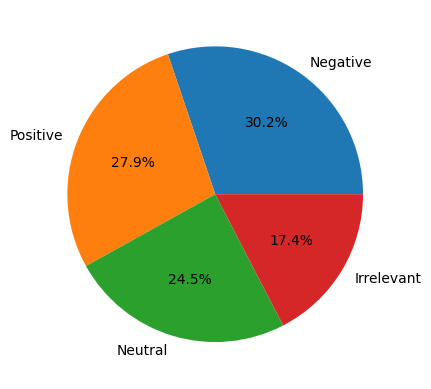

In [ ]:
plt.pie(df['sentiment'].value_counts(),labels = ['Negative','Positive','Neutral','Irrelevant'], autopct = "%1.1f%%")
plt.show()

In [ ]:
import wordcloud

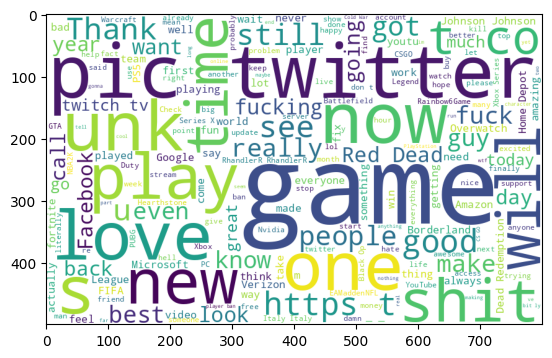

In [ ]:
wc = wordcloud.WordCloud(background_color='white', width=800, height=500)
wc.generate(' '.join(df['content'].astype(str)))
plt.imshow(wc)
plt.show()

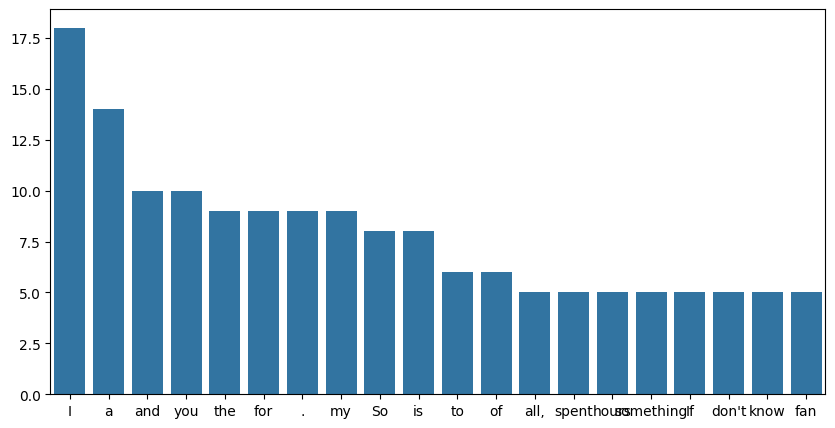

In [ ]:
words = ' '.join(df['content'][:10]).split()
word_freq = Counter(words).most_common(20)
words, counts = zip(*word_freq)
plt.figure(figsize=(10,5))
sns.barplot(x = list(words), y = list(counts))
plt.show()

Image EDA

In [ ]:

import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Path to all images (recursively from subfolders)
all_image_paths = glob.glob("E:/Xai_Req_Setup/Notebooks/datasets/Oxford 17 Flowers/*/*.jpg")

# Extract class names from folder structure
class_names = [path.split("\\")[-2] for path in all_image_paths]


In [ ]:

# STEP 1: Class Distribution
df = pd.DataFrame({"path": all_image_paths, "class": class_names})
class_counts = df['class'].value_counts()

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.title("Image Count per Flower Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [ ]:

# STEP 2: Show Sample Images
plt.figure(figsize=(16, 10))
for i, cls in enumerate(df['class'].unique()[:12]):
    img_path = df[df['class'] == cls].iloc[0]['path']
    img = Image.open(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample Images from Oxford 17 Flowers", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:

# STEP 3: RGB Histogram of a few images
for cls in df['class'].unique()[:5]:  # First 5 classes
    img_path = df[df['class'] == cls].iloc[0]['path']
    img = Image.open(img_path).resize((256, 256))
    img_arr = np.array(img)

    plt.figure(figsize=(6, 3))
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        plt.hist(img_arr[:, :, i].flatten(), bins=256, color=color, alpha=0.6, label=f'{color.upper()} channel')

    plt.title(f"RGB Histogram: {cls}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()